In [1]:
import pandas as pd
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf

In [7]:
def load_data(ticker):
    return yf.download(ticker, period="max", interval="1d", progress=False)

def preprocess(raw_data):    
    data = raw_data[["Close"]]
    data.reset_index(inplace=True)
    data.set_index("Date", inplace=True)    
    return data

def split_data(series, train_fraq, test_len):
    test_slice = len(series)-test_len

    test_data = series[test_slice:]
    train_val_data = series[:test_slice]
    train_size = int(len(train_val_data) * train_fraq)
    
    train_data = train_val_data[:train_size]
    val_data = train_val_data[train_size:]
    
    return train_data, val_data, test_data

def window_dataset(data, n_steps, n_horizon, batch_size, shuffle_buffer, expand_dims=False):
    window = n_steps + n_horizon
    if expand_dims:
        ds = tf.expand_dims(data, axis=-1)
        ds = tf.data.Dataset.from_tensor_slices(ds)
    else:
        ds = tf.data.Dataset.from_tensor_slices(data)
    ds = ds.window(window, shift=n_horizon, drop_remainder=True)
    ds = ds.flat_map(lambda x : x.batch(window))
    ds = ds.shuffle(shuffle_buffer)    
    ds = ds.map(lambda x : (x[:-n_horizon], x[-n_horizon:, :1]))
    ds = ds.batch(batch_size).prefetch(1)
    
    return ds

In [8]:
def build_dataset(ticker, train_fraq=0.65, n_steps=24*30, n_horizon=24, batch_size=256, shuffle_buffer=500, expand_dims=False):
    
    tf.random.set_seed(0)
    
    data = load_data(ticker)
    
    data = preprocess(data)

    scaler = MinMaxScaler()
    df = scaler.fit_transform(data)

    train_data, val_data, test_data = split_data(df, train_fraq=train_fraq, test_len=1000)
    
    train_ds = window_dataset(train_data, n_steps, n_horizon, batch_size, shuffle_buffer, expand_dims=expand_dims)
    val_ds = window_dataset(val_data, n_steps, n_horizon, batch_size, shuffle_buffer, expand_dims=expand_dims)
    test_ds = window_dataset(test_data, n_steps, n_horizon, batch_size, shuffle_buffer, expand_dims=expand_dims)
    
    return train_ds, val_ds, test_ds

In [4]:
def lstm_cnn_model(name, n_steps, n_horizon, n_features, lr, bi=False):
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(64, kernel_size=6, activation='relu', input_shape=(n_steps,n_features)),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.LSTM(72, activation='relu', return_sequences=True) if not bi else tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(72, activation='relu', return_sequences=True)),
        tf.keras.layers.LSTM(48, activation='relu', return_sequences=True) if not bi else tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(72, activation='relu', return_sequences=True)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name=name)
    
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])
    
    return model

In [25]:
def bi_lstm_cnn_model(name, n_steps, n_horizon, n_features, lr, bi):
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(64, kernel_size=1, activation='relu', input_shape=(n_steps,n_features)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, activation='relu', return_sequences=True)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, activation='relu', return_sequences=True)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, activation='relu', return_sequences=True)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(50, activation='relu', kernal_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(n_horizon)
    ], name=name)
    
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])
    
    return model

In [5]:
def lstm_cnn_skip_model(name, n_steps, n_horizon, n_features, lr, bi):
    
    tf.keras.backend.clear_session()
       
    inputs = tf.keras.layers.Input(shape=(n_steps,n_features), name='main')
    
    conv1 = tf.keras.layers.Conv1D(64, kernel_size=6, activation='relu')(inputs)
    max_pool_1 = tf.keras.layers.MaxPooling1D(2)(conv1)
    conv2 = tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu')(max_pool_1)
    max_pool_2 = tf.keras.layers.MaxPooling1D(2)(conv2)
    lstm_1 = tf.keras.layers.LSTM(72, activation='relu', return_sequences=True)(max_pool_2) if not bi else tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(72, activation='relu', return_sequences=True))(max_pool_2)
    lstm_2 = tf.keras.layers.LSTM(48, activation='relu', return_sequences=False)(lstm_1) if not bi else tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(72, activation='relu', return_sequences=False))(lstm_1)
    dense_0 = tf.keras.layers.Dense(48, activation='relu')(lstm_2)
    flatten = tf.keras.layers.Flatten()(dense_0)
    
    skip_flatten = tf.keras.layers.Flatten()(inputs)

    concat = tf.keras.layers.Concatenate(axis=-1)([flatten, skip_flatten])
    drop_1 = tf.keras.layers.Dropout(0.3)(concat)
    dense_1 = tf.keras.layers.Dense(128, activation='relu')(drop_1)
    drop_2 = tf.keras.layers.Dropout(0.3)(dense_1)
    output = tf.keras.layers.Dense(n_horizon)(drop_2)
    
    model = tf.keras.Model(inputs=inputs, outputs=output, name=name)
    
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])
    
    return model

In [26]:
dataset_index = 0
n_steps, n_horizon = 24*30, 24
model_configs = {}

models = {
    "bi_lstm_cnn": bi_lstm_cnn_model,
    "lstm_cnn_skip": lstm_cnn_skip_model,
    "lstm_cnn": lstm_cnn_model,
}

def get_params(train_ds):
    return n_steps, n_horizon, train_ds.element_spec[0].shape[-1], 0.001

def get_model_params(epochs=200, batch_size=1024):
    return epochs, batch_size

def run_model(model_name, model, epochs, batch_size, model_configs, bi):
    train_ds, val_ds, test_ds = build_dataset("LTC-EUR", n_steps=n_steps, n_horizon=n_horizon)
    model = model(model_name, *get_params(train_ds), bi=bi)
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[TqdmCallback(verbose=1)])
    model_configs[model_name] = {"model": model, "history" : history, "test_ds": test_ds}

for model_name, model in models.items():
    for bi in [False, True]:
        run_model(model_name, model, *get_model_params(), model_configs, bi)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

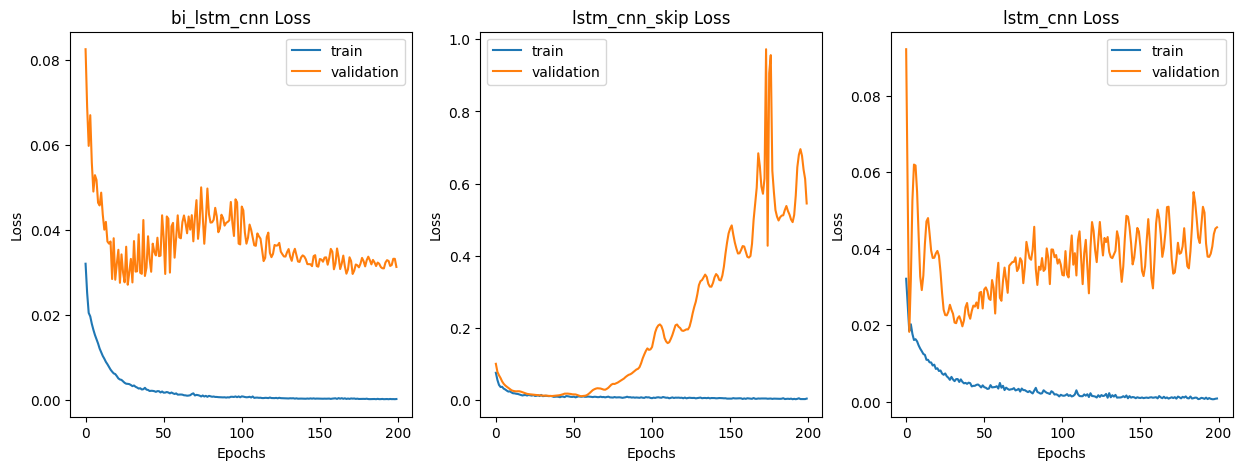

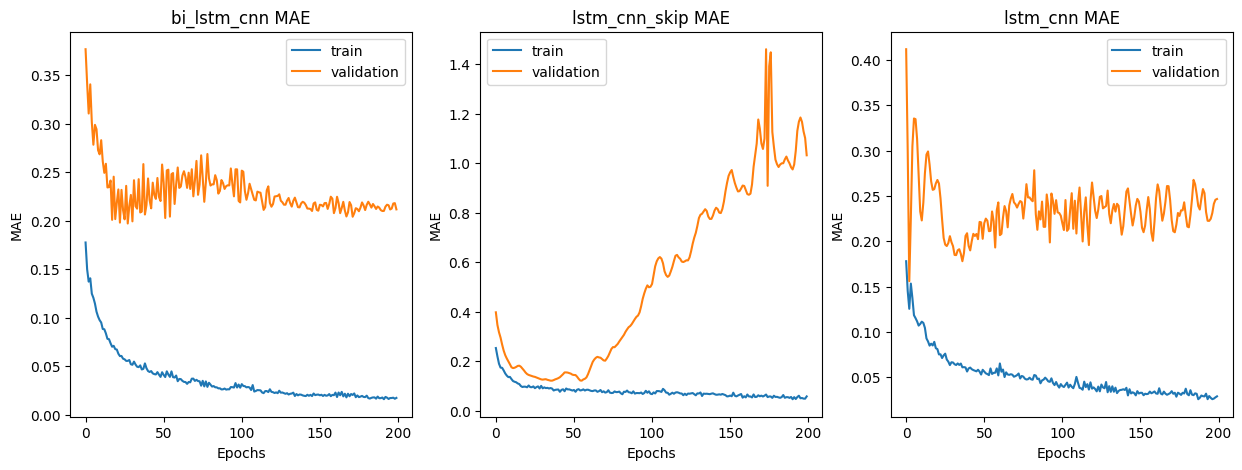

In [28]:
def plot_loss(model_configs):
    _, axs = plt.subplots(1, len(model_configs), figsize=(len(model_configs) * 5, 5))
    for (k, v), ax in zip(model_configs.items(), axs.flatten()):
        ax.plot(v['history'].history['loss'], label='train')
        ax.plot(v['history'].history['val_loss'], label='validation')
        ax.set_title(f"{k} Loss")
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        ax.legend()

def plot_mae(model_configs):
    _, axs = plt.subplots(1, len(model_configs), figsize=(len(model_configs) * 5, 5))
    for (k, v), ax in zip(model_configs.items(), axs.flatten()):
        ax.plot(v['history'].history['mae'], label='train')
        ax.plot(v['history'].history['val_mae'], label='validation')
        ax.set_title(f"{k} MAE")
        ax.set_xlabel('Epochs')
        ax.set_ylabel('MAE')
        ax.legend()

plot_loss(model_configs)
plot_mae(model_configs)

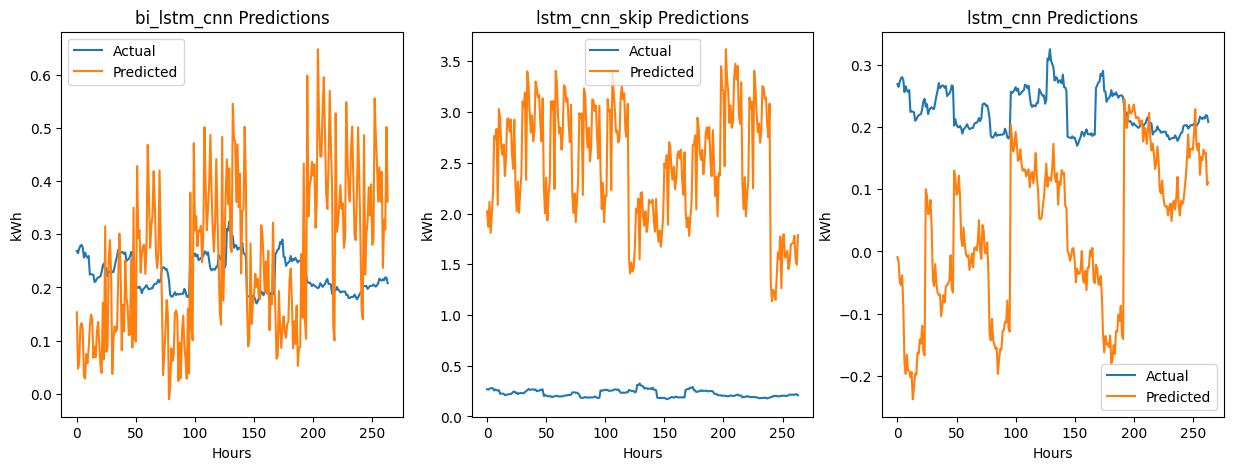

In [29]:
def plot_predictions(model_configs, days=14):
    _, axs = plt.subplots(1, len(model_configs), figsize=(len(model_configs) * 5, 5))
    for (k, _), ax in zip(model_configs.items(), axs.flatten()):
        test = model_configs[k]["test_ds"]
        pred = model_configs[k]["model"].predict(test, verbose=0)
        _, ybatch = iter(test).next()

        ax.plot(ybatch.numpy()[:days].reshape(-1))
        ax.plot(pred[:days].reshape(-1))
        ax.set_title(f"{k} Predictions")
        ax.set_xlabel('Hours')
        ax.set_ylabel('kWh')
        ax.legend(['Actual', 'Predicted'])
        
plot_predictions(model_configs)